In [1]:
import pandas as pd

In [5]:
# 检查数据
def check_data(data):
    print("数据的前几行：")
    display(data.head())
    print("\n数据的信息：")
    data.info()
    print("\n数据是否有缺失值：")
    print(data.isnull().sum())
    print("\n数据的描述统计信息：")
    display(data.describe())

file_path = 'data\merged_data.xlsx'
data = pd.read_excel(file_path)
check_data(data)

数据的前几行：


,DATE,DPRIME,Close/Last,Volume,Open,High,Low
0,2014-06-24,3.25,25.34,243530,25.52,25.980,25.303
1,2014-06-25,3.25,25.27,491864,25.24,25.490,24.570
2,2014-06-26,3.25,25.45,342669,26.00,26.000,25.210
3,2014-06-27,3.25,24.69,1482237,25.24,25.405,24.690
4,2014-06-30,3.25,25.27,648122,24.69,25.390,24.610



数据的信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        2516 non-null   object 
 1   DPRIME      2516 non-null   float64
 2   Close/Last  2516 non-null   float64
 3   Volume      2516 non-null   int64  
 4   Open        2516 non-null   float64
 5   High        2516 non-null   float64
 6   Low         2516 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 137.7+ KB

数据是否有缺失值：
DATE          0
DPRIME        0
Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64

数据的描述统计信息：


,DPRIME,Close/Last,Volume,Open,High,Low
count,2516.000000,2516.000000,2.516000e+03,2516.000000,2516.000000,2516.000000
mean,4.659777,83.135227,1.053906e+06,83.038848,85.631164,80.514331
std,1.746143,175.929359,2.374987e+06,176.078881,182.858264,168.801560
min,3.250000,11.650000,3.038000e+03,11.550000,12.160000,8.500000
25%,3.250000,23.035000,2.295038e+05,23.000000,23.472500,22.630000
50%,4.000000,27.955000,3.733460e+05,28.005000,28.555000,27.500000
75%,5.500000,40.150000,7.029622e+05,40.132500,40.702450,39.330000
max,8.500000,1188.070000,3.403834e+07,1212.000000,1229.000000,1122.340000


In [6]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import datetime as dt
import matplotlib.pyplot as plt

In [7]:
# 目前用的是tensorflow
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [8]:
data

,DATE,DPRIME,Close/Last,Volume,Open,High,Low
0,2014-06-24,3.25,25.340,243530,25.52,25.9800,25.303
1,2014-06-25,3.25,25.270,491864,25.24,25.4900,24.570
2,2014-06-26,3.25,25.450,342669,26.00,26.0000,25.210
3,2014-06-27,3.25,24.690,1482237,25.24,25.4050,24.690
4,2014-06-30,3.25,25.270,648122,24.69,25.3900,24.610
...,...,...,...,...,...,...,...
2511,2024-06-14,8.50,844.540,6598781,846.93,872.0000,825.610
2512,2024-06-17,8.50,887.410,8911764,857.40,921.9100,828.090
2513,2024-06-18,8.50,920.010,8762073,897.00,938.8800,883.310
2514,2024-06-20,8.50,917.635,13432940,961.29,1014.0200,900.320


In [24]:
#adjust：timesteps
time_steps0 = 30
time_steps1 = 60
time_steps2 = 90

In [54]:
time_steps = time_steps1

In [49]:
from sklearn.preprocessing import StandardScaler

In [55]:
# pre-processing
def preprocess_data(train_set, valid_set):
    #scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = StandardScaler()
    
    # normalization
    train_data = scaler.fit_transform(train_set['Close/Last'].values.reshape(-1, 1))
    valid_data = scaler.transform(valid_set['Close/Last'].values.reshape(-1, 1))
    
    x_train, y_train = [], []
    for i in range(time_steps, len(train_data)):
        x_train.append(train_data[i-time_steps:i, 0])
        y_train.append(train_data[i, 0])
    
    x_valid, y_valid = [], []
    for i in range(time_steps, len(valid_data)):
        x_valid.append(valid_data[i-time_steps:i, 0])
        y_valid.append(valid_data[i, 0])
    
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    x_valid, y_valid = np.array(x_valid), np.array(y_valid)
    x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))
    
    return x_train, y_train, x_valid, y_valid, scaler

In [56]:
# train parameter：LSTM
def build_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [57]:
# train model
def train_model(model, x_train, y_train):
    model.fit(x_train, y_train, epochs=25, batch_size=32)

In [58]:
# predict
def make_prediction(model, x_valid, scaler):
    predictions = model.predict(x_valid)
    predictions = scaler.inverse_transform(predictions)
    return predictions

In [14]:
data['DATE'] = pd.to_datetime(data['DATE'])
train_set = data[(data['DATE'] >= '2014-06-24') & (data['DATE'] < '2023-06-24')].copy()
valid_set = data[(data['DATE'] >= '2023-06-24') & (data['DATE'] < '2024-06-24')].copy()

In [15]:
train_set

,DATE,DPRIME,Close/Last,Volume,Open,High,Low
0,2014-06-24,3.25,25.34,243530,25.52,25.9800,25.303
1,2014-06-25,3.25,25.27,491864,25.24,25.4900,24.570
2,2014-06-26,3.25,25.45,342669,26.00,26.0000,25.210
3,2014-06-27,3.25,24.69,1482237,25.24,25.4050,24.690
4,2014-06-30,3.25,25.27,648122,24.69,25.3900,24.610
...,...,...,...,...,...,...,...
2261,2023-06-16,8.25,230.77,3034647,245.00,245.7800,230.370
2262,2023-06-20,8.25,222.40,3366546,227.30,235.7096,219.330
2263,2023-06-21,8.25,219.91,2603561,221.00,227.0000,217.200
2264,2023-06-22,8.25,226.46,3938637,221.99,241.9699,221.140


# time_steps = 30

In [30]:
# call pre-processing
x_train, y_train, x_valid, y_valid, scaler = preprocess_data(train_set, valid_set)
# train model
model = build_model()
train_model(model, x_train, y_train)
# make prediction
valid_preds = make_prediction(model, x_valid, scaler)

D:\Users\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.0033
Epoch 2/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 7.0909e-04
Epoch 3/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 4.7565e-04
Epoch 4/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 6.8910e-04
Epoch 5/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 4.9487e-04
Epoch 6/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 4.1263e-04
Epoch 7/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 5.1691e-04
Epoch 8/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 4.0463e-04
Epoch 9/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 3.8388e-04
Epoch 10/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 3.3611e-04
Epoch 11/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 3.4644e-04
Epoch 12/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 4.4955e-04
Epoch 13/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 2.9067e-04
Epoch 14/25
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 3.3503e-04
Epoch 15/25
70/70 ━

LSTM RMSE on validation set: 201.27462880684052


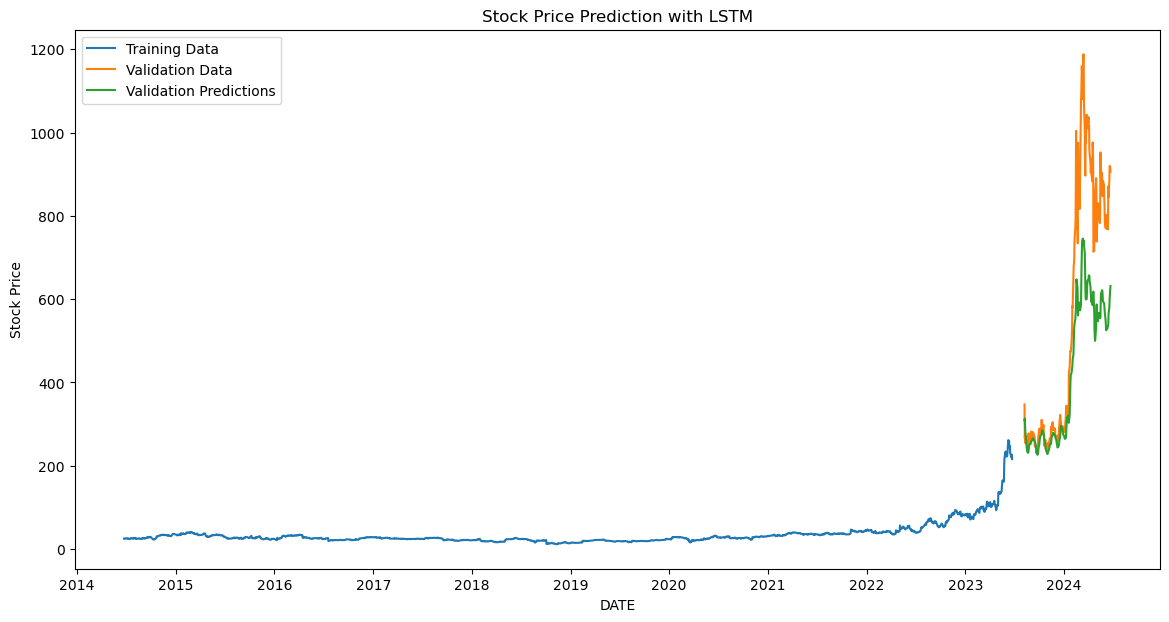

In [34]:
# validate by RMSE
valid_rmse = np.sqrt(mean_squared_error(valid_set['Close/Last'].values[time_steps:], valid_preds))
print(f"LSTM RMSE on validation set: {valid_rmse}")

# visualize
plt.figure(figsize=(14, 7))
plt.plot(train_set['DATE'], train_set['Close/Last'], label='Training Data')
plt.plot(valid_set['DATE'][time_steps:], valid_set['Close/Last'].values[time_steps:], label='Validation Data')
plt.plot(valid_set['DATE'][time_steps:], valid_preds, label='Validation Predictions')
plt.xlabel('DATE')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with LSTM')
plt.legend()
plt.show()

# time_steps = 60

In [40]:
# call pre-processing
x_train, y_train, x_valid, y_valid, scaler = preprocess_data(train_set, valid_set)
# train model
model = build_model()
train_model(model, x_train, y_train)
# make prediction
valid_preds = make_prediction(model, x_valid, scaler)

Epoch 1/25


D:\Users\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.0078
Epoch 2/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 5.0291e-04
Epoch 3/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 8.2000e-04
Epoch 4/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 5.0109e-04
Epoch 5/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 7.2296e-04
Epoch 6/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 4.5294e-04
Epoch 7/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 7.0125e-04
Epoch 8/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 3.7511e-04
Epoch 9/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 4.2512e-04
Epoch 10/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 4.2103e-04
Epoch 11/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 4.9263e-04
Epoch 12/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.6530e-04
Epoch 13/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 3.1640e-04
Epoch 14/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 3.6818e-04
Epoch 15/25
69/69 ━━━━━━━━━━━━

LSTM RMSE on validation set: 171.23221161672578


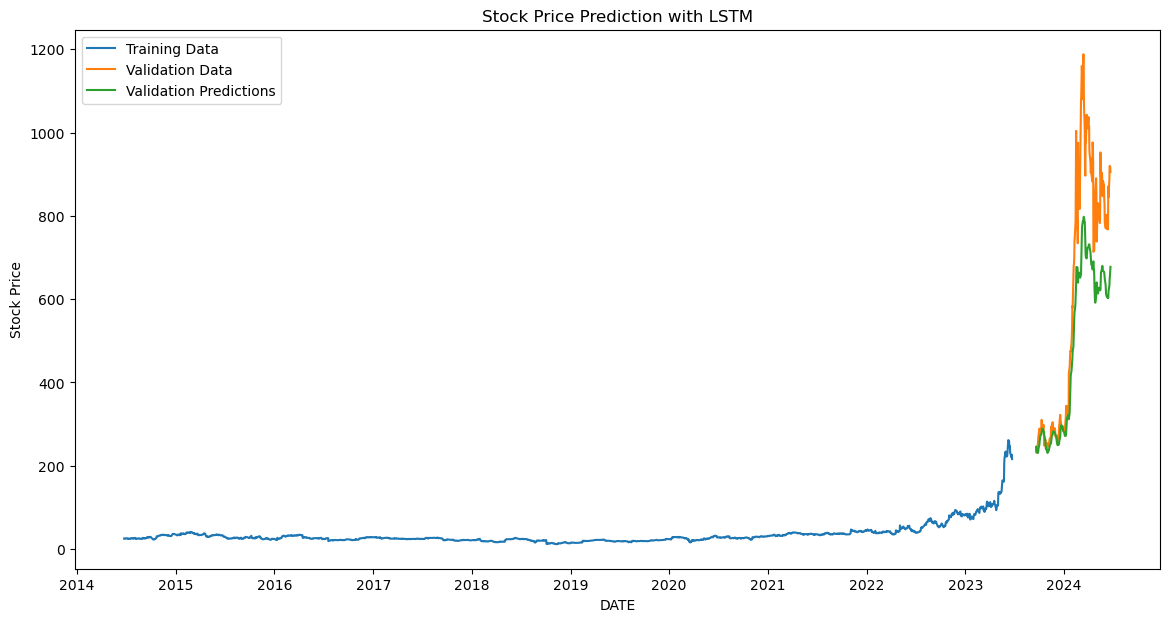

In [41]:
# validate by RMSE
valid_rmse = np.sqrt(mean_squared_error(valid_set['Close/Last'].values[time_steps:], valid_preds))
print(f"LSTM RMSE on validation set: {valid_rmse}")

# visualize
plt.figure(figsize=(14, 7))
plt.plot(train_set['DATE'], train_set['Close/Last'], label='Training Data')
plt.plot(valid_set['DATE'][time_steps:], valid_set['Close/Last'].values[time_steps:], label='Validation Data')
plt.plot(valid_set['DATE'][time_steps:], valid_preds, label='Validation Predictions')
plt.xlabel('DATE')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with LSTM')
plt.legend()
plt.show()

# time_steps = 90

In [47]:
# call pre-processing
x_train, y_train, x_valid, y_valid, scaler = preprocess_data(train_set, valid_set)
# train model
model = build_model()
train_model(model, x_train, y_train)
# make prediction
valid_preds = make_prediction(model, x_valid, scaler)

Epoch 1/25


D:\Users\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 0.0045
Epoch 2/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 6.4375e-04
Epoch 3/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 6.3542e-04
Epoch 4/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 4.2053e-04
Epoch 5/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 6.7700e-04
Epoch 6/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 3.6892e-04
Epoch 7/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 9.9524e-04
Epoch 8/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 6.2004e-04
Epoch 9/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 5.7187e-04
Epoch 10/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 3.4626e-04
Epoch 11/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 5.7376e-04
Epoch 12/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 3.1593e-04
Epoch 13/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 5.0730e-04
Epoch 14/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 3.3192e-04
Epoch 15/25
68/68 ━━━━━━━━━━━━

LSTM RMSE on validation set: 209.3798309910535


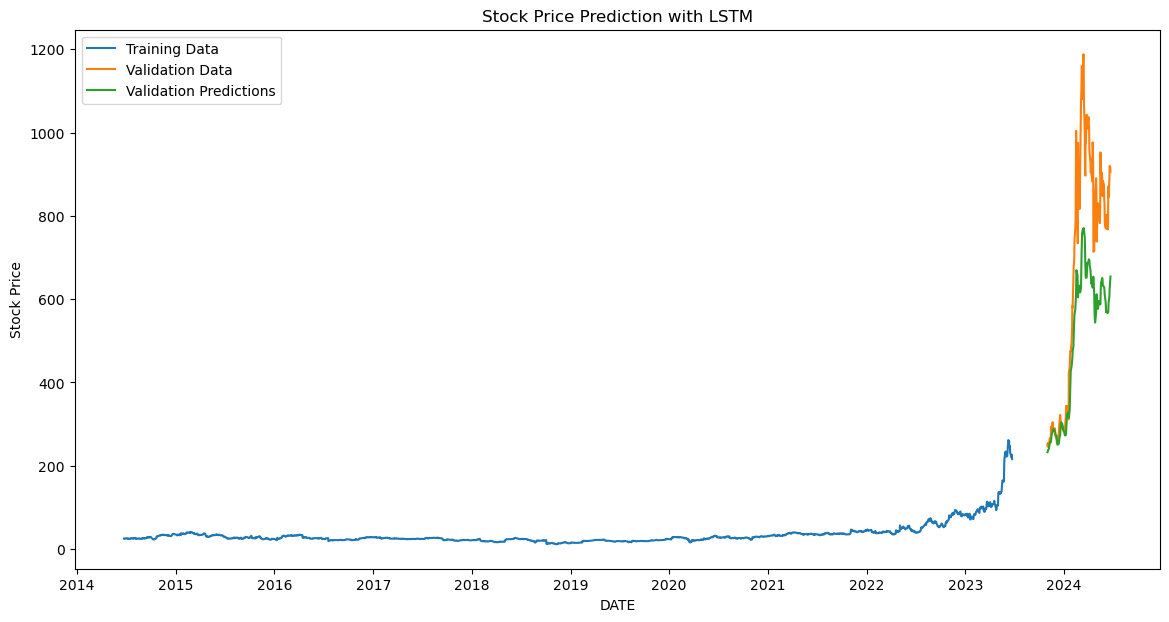

In [48]:
# validate by RMSE
valid_rmse = np.sqrt(mean_squared_error(valid_set['Close/Last'].values[time_steps:], valid_preds))
print(f"LSTM RMSE on validation set: {valid_rmse}")

# visualize
plt.figure(figsize=(14, 7))
plt.plot(train_set['DATE'], train_set['Close/Last'], label='Training Data')
plt.plot(valid_set['DATE'][time_steps:], valid_set['Close/Last'].values[time_steps:], label='Validation Data')
plt.plot(valid_set['DATE'][time_steps:], valid_preds, label='Validation Predictions')
plt.xlabel('DATE')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with LSTM')
plt.legend()
plt.show()

# use StandardScaler instead of MinMaxScaler

In [59]:
# call pre-processing
x_train, y_train, x_valid, y_valid, scaler = preprocess_data(train_set, valid_set)
# train model
model = build_model()
train_model(model, x_train, y_train)
# make prediction
valid_preds = make_prediction(model, x_valid, scaler)

D:\Users\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 0.4173
Epoch 2/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0282
Epoch 3/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0245
Epoch 4/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0253
Epoch 5/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 0.0224
Epoch 6/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.0253
Epoch 7/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0257
Epoch 8/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0214
Epoch 9/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0224
Epoch 10/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0219
Epoch 11/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0186
Epoch 12/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0231
Epoch 13/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0175
Epoch 14/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0193
Epoch 15/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0203
Epoc

LSTM RMSE on validation set: 465.15327136256775


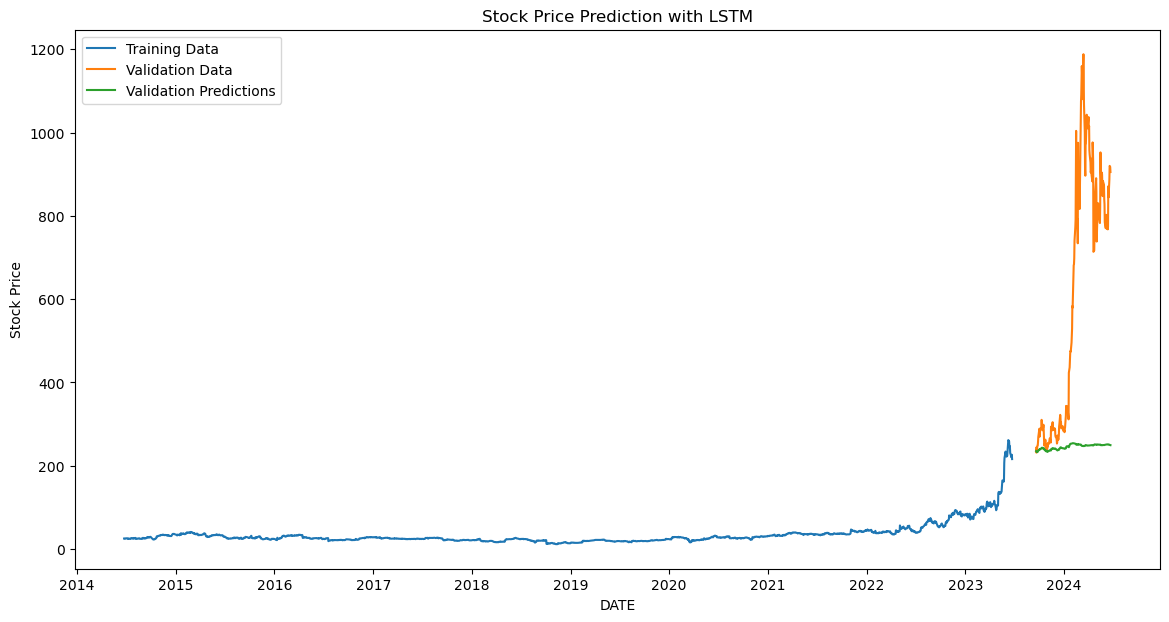

In [60]:
# validate by RMSE
valid_rmse = np.sqrt(mean_squared_error(valid_set['Close/Last'].values[time_steps:], valid_preds))
print(f"LSTM RMSE on validation set: {valid_rmse}")

# visualize
plt.figure(figsize=(14, 7))
plt.plot(train_set['DATE'], train_set['Close/Last'], label='Training Data')
plt.plot(valid_set['DATE'][time_steps:], valid_set['Close/Last'].values[time_steps:], label='Validation Data')
plt.plot(valid_set['DATE'][time_steps:], valid_preds, label='Validation Predictions')
plt.xlabel('DATE')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with LSTM')
plt.legend()
plt.show()